In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']


# hyperparameters
K = 3
N_e = 75
N_i = N_e
N = N_e + N_i
D = 30
sparsity = 0.25
U = 50
T = 100
N_weights = int (N * N * sparsity)

zeta_alpha_beta_gamma_list = [(10**i,1,1,10**(i-2)) for i in list(np.arange(-2,0.5,0.5))]

(0.0, 50.0)

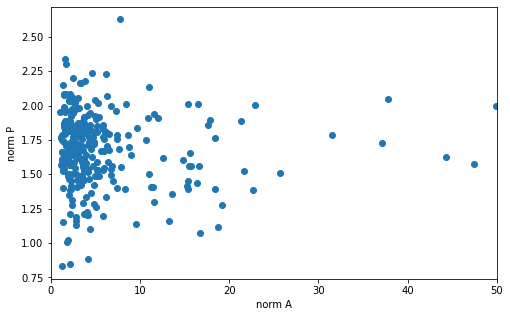

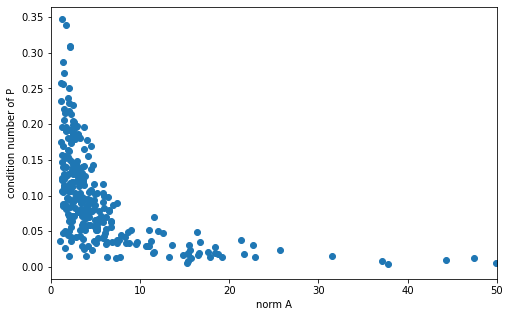

In [60]:
eigenvalues = np.load(f'models/eigenvalues_K=3_eig=0.npy')
def generate_dynamics_A1(eigenvalues):
    comp_A = scipy.linalg.companion(np.poly((eigenvalues))) # companion matrix from characteristic polynomial
    K = eigenvalues.shape[0]
    # generate real random matrix for similarity transformation of companion matrix for given eigenvalues
    P = np.random.rand(K,K) # uniform (0,1)
    trueA = np.linalg.inv(P)  @ comp_A @ P # similarity
    return trueA, comp_A, P

simulations = 300
norm_P = np.zeros((simulations))
norm_A = np.zeros((simulations))
norm_PP = np.zeros((simulations))
cond_P = np.zeros((simulations))

for simulation in range(simulations):
    trueA, comp_A, P = generate_dynamics_A1(eigenvalues)
    norm_P[simulation] = np.sqrt(np.trace(P.T @ P))
    norm_A[simulation] = np.sqrt(np.trace(trueA.T @ trueA))
    PP = P @ P.T
    norm_PP[simulation] = np.sqrt(np.trace(PP.T @ PP))

    U, S, Vh = np.linalg.svd(P)

    cond_P[simulation] = np.linalg.cond(P, p=-2)
    eigval_P, eigvec_P = np.linalg.eig(P)
    eigval_P_inv, eigvec_P_inv = np.linalg.eig(np.linalg.inv(P))

# no relationship with norm of P
fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(norm_A, norm_P)
axes.set_xlabel('norm A')
axes.set_ylabel('norm P')
axes.set_xlim(0,50)

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(norm_A, cond_P)
axes.set_xlabel('norm A')
axes.set_ylabel('condition number of P')
axes.set_xlim(0,50)

In [56]:
# load fit models
initW0 = np.empty((10, 30), dtype=object)
initW = np.empty((10, 30), dtype=object)
loss_W = np.empty((10, 30), dtype=object)
w_all = np.empty((10, 30), dtype=object)
lossW = np.empty((10, 30), dtype=object)
w = np.empty((10, 30), dtype=object)
b = np.empty((10, 30), dtype=dict)
s = np.empty((10, 30), dtype=object)
mu0 = np.empty((10, 30), dtype=object)
Q0 = np.empty((10, 30), dtype=object)
C_ = np.empty((10, 30), dtype=object)
d = np.empty((10, 30), dtype=object)
R = np.empty((10, 30), dtype=object)
J = np.empty((10, 30), dtype=object)
true_x= np.empty((10, 30), dtype=object)
true_y= np.empty((10, 30), dtype=object)
trueA= np.empty((10, 30), dtype=object)
true_b= np.empty((10, 30), dtype=dict)
true_s= np.empty((10, 30), dtype=object)
true_mu0= np.empty((10, 30), dtype=object)
true_Q0= np.empty((10, 30), dtype=object)
true_C_= np.empty((10, 30), dtype=object)
true_d= np.empty((10, 30), dtype=object)
true_R= np.empty((10, 30), dtype=object)
fitW = np.empty((10,30), dtype=object)

for eig in range(10):
    print(eig)
    for simulation in range(30):

        init = np.load(f'models/N={N}_K={K}_eig-set={eig}_simulation={simulation}_initialization_weights.npz', allow_pickle=True)
        initW0[eig,simulation] = init['initW'] 
        initW[eig,simulation] = init['initW'] 
        loss_W[eig,simulation] = init['loss_W']
        w_all[eig,simulation] = init['w_all']
        fits = np.load(f'models/N={N}_K={K}_eig-set={eig}_simulation={simulation}_fitting_EM.npz', allow_pickle=True)
        lossW[eig,simulation] = fits['lossW']
        w[eig,simulation] = fits['w']
        b[eig,simulation] = fits['b']
        s[eig,simulation] = fits['s']
        mu0[eig,simulation] = fits['mu0']
        Q0[eig,simulation] = fits['Q0']
        C_[eig,simulation] = fits['C_']
        d[eig,simulation] = fits['d']
        R[eig,simulation] = fits['R']
        true = np.load(f'models/N={N}_K={K}_eig-set={eig}_simulation={simulation}_true_parameters_and_data.npz', allow_pickle=True)
        J[eig,simulation] = true['J']
        true_x[eig,simulation] = true['true_x']
        true_y[eig,simulation] = true['true_y']
        trueA[eig,simulation] = true['trueA']
        true_b[eig,simulation] = true['true_b']
        true_s[eig,simulation] = true['true_s']
        true_mu0[eig,simulation] = true['true_mu0']
        true_Q0[eig,simulation] = true['true_Q0']
        true_C_[eig,simulation] = true['true_C_']
        true_d[eig,simulation] = true['true_d']
        true_R[eig,simulation] = true['true_R']

        RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig, simulation],  seed=1)
        fitW[eig,simulation] = RNN.build_full_weight_matrix(w[eig,simulation])


0
1
2
3
4
5
6
7
8
9


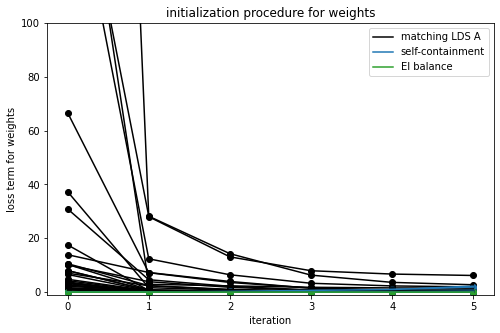

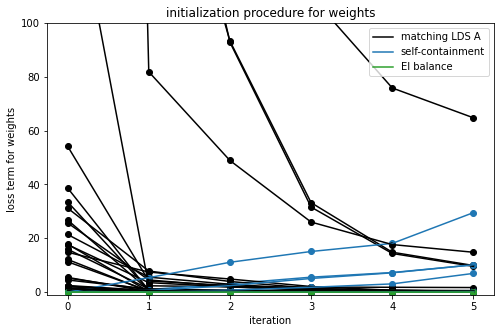

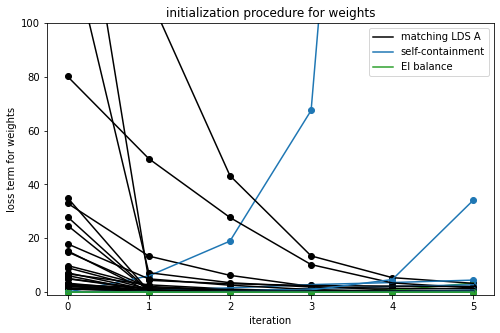

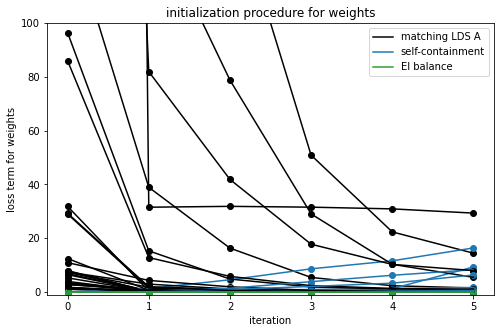

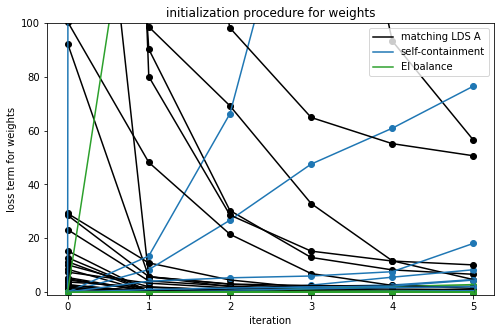

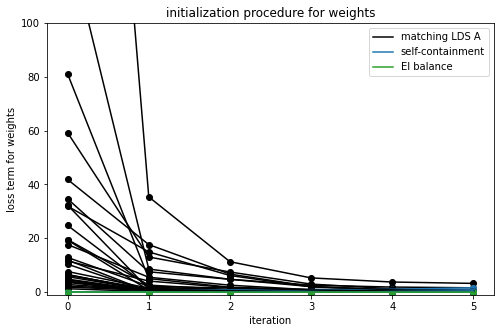

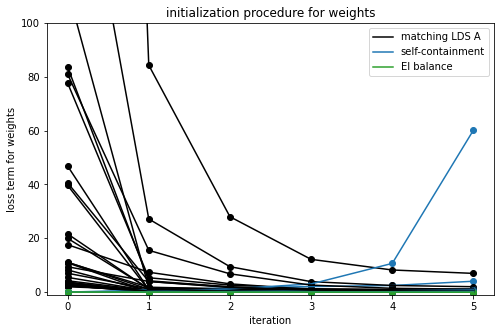

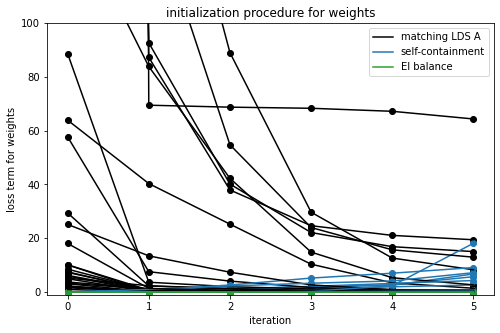

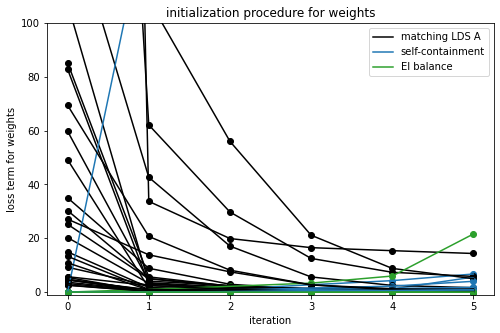

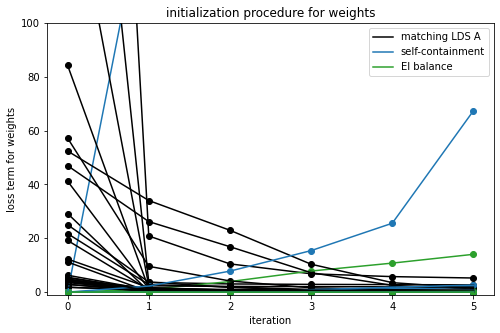

In [3]:
# inspect initialization
norm_A = np.zeros((10,30))
for eig in range(10):
    fig, axes = plt.subplots(figsize=(8,5))
    for simulation in range(30):
        norm_A[eig,simulation] = np.sqrt(np.trace(trueA[eig,simulation].T @ trueA[eig,simulation]))

        if simulation == 0:
            axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,0], color='black', label='matching LDS A')
            axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,0], color='black')
            axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,1], color='tab:blue', label='self-containment')
            axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,1], color='tab:blue')
            axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,2], color='tab:green', label='EI balance')
            axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,2], color='tab:green')
        else:
            axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,0], color='black')
            axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,0], color='black')
            axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,1], color='tab:blue')
            axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,1], color='tab:blue')
            axes.plot(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,2], color='tab:green')
            axes.scatter(range(len(zeta_alpha_beta_gamma_list)+1), loss_W[eig,simulation][:,2], color='tab:green')
    axes.set_title('initialization procedure for weights')
    axes.set_ylabel('loss term for weights')
    axes.set_xlabel('iteration')
    axes.legend(loc='upper right')
    axes.set_ylim(-1,100)


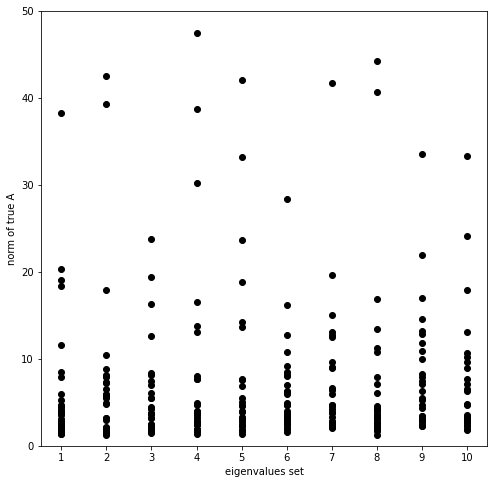

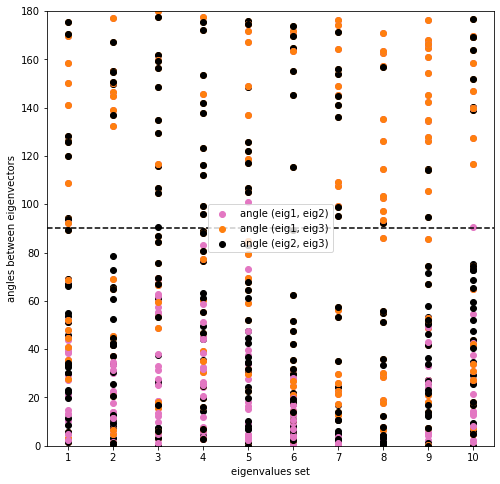

In [4]:
fig, axes = plt.subplots(figsize=(8,8))
for eig in range(10):
    for simulation in range(30):
        axes.scatter(eig, norm_A[eig,simulation],color='black')
axes.set_ylabel('norm of true A')
axes.set_ylim(0,50)
axes.set_xlabel('eigenvalues set')
axes.set_xticks(range(10),range(1,11))

fig, axes = plt.subplots(figsize=(8,8))
for eig in range(10):
    for simulation in range(30):
        _, eigvec = np.linalg.eig(trueA[eig,simulation])
        axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,1]), color='tab:pink')
        axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,2]), color='tab:orange')
        axes.scatter(eig, angle_vectors(eigvec[:,1], eigvec[:,2]), color='black')

axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,1]), color='tab:pink', label='angle (eig1, eig2)')
axes.scatter(eig, angle_vectors(eigvec[:,0], eigvec[:,2]), color='tab:orange', label='angle (eig1, eig3)')
axes.scatter(eig, angle_vectors(eigvec[:,1], eigvec[:,2]), color='black', label='angle (eig2, eig3)')
axes.set_ylabel('angles between eigenvectors')
axes.set_ylim(0,180)
axes.set_xlabel('eigenvalues set')
axes.axhline(90, color='black', linestyle='dashed')
axes.legend()
axes.set_xticks(range(10),range(1,11))



Text(0.5, 0, 'eigenvalue set')

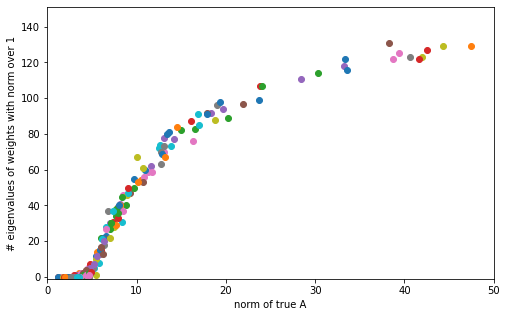

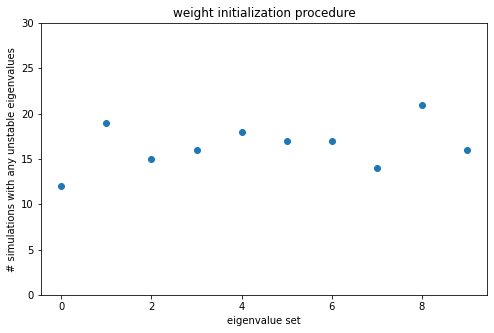

In [29]:
def norm_complex_scalar(eig):
    eig_norms = np.zeros((eig.shape[0]))
    for i in range(eig_norms.shape[0]):
        eig_norms[i] = np.sqrt(np.real(eig[i])**2 + np.imag(eig[i])**2)
    return eig_norms

binary_unstable_init = np.zeros((10, 30))
count_unstable_init = np.zeros((10, 30))
fig, axes = plt.subplots(figsize=(8,5))
for eig in range(10):
    for simulation in range(30):
        eig_init = np.linalg.eigvals(initW[eig,simulation]) 
        eig_norms = norm_complex_scalar(eig_init)

        if len(np.argwhere(eig_norms > 1)) > 0:
            binary_unstable_init[eig, simulation] = 1
            count_unstable_init[eig, simulation] = len(np.argwhere(eig_norms > 1))

        axes.scatter(norm_A[eig,simulation], count_unstable_init[eig,simulation])
axes.set_xlim(0,50)
axes.set_ylabel('# eigenvalues of weights with norm over 1')
axes.set_ylim(-1,N+1)
axes.set_xlabel('norm of true A')

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(range(10),binary_unstable_init.sum(axis=1))
axes.set_ylim(0,30)
axes.set_ylabel('# simulations with any unstable eigenvalues')
axes.set_title('weight initialization procedure')
axes.set_xlabel('eigenvalue set')

# what properties of A correlate with its norm?


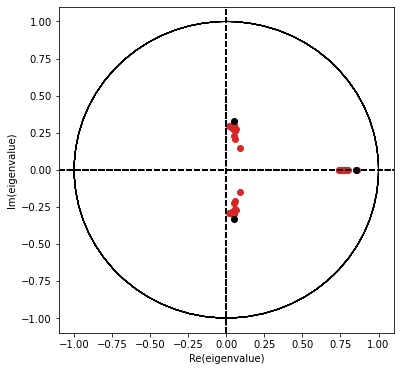

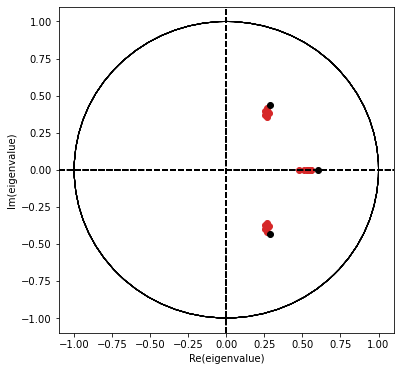

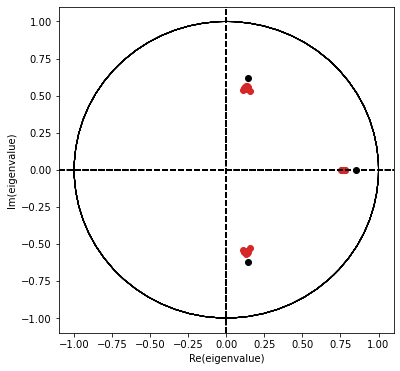

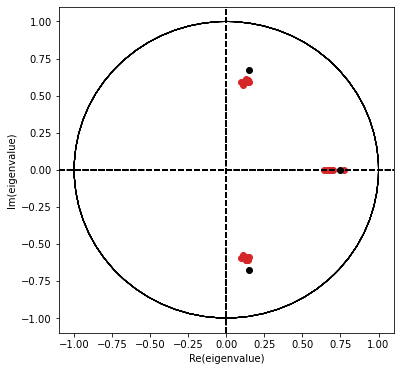

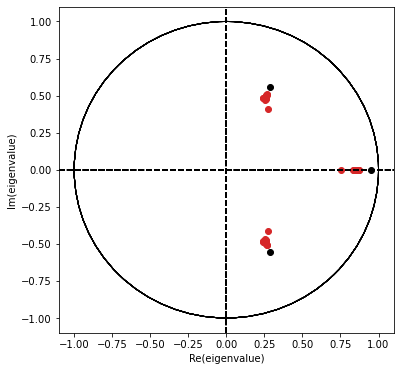

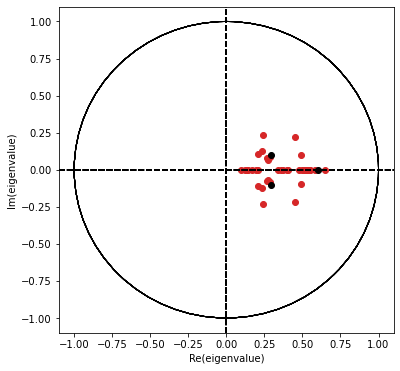

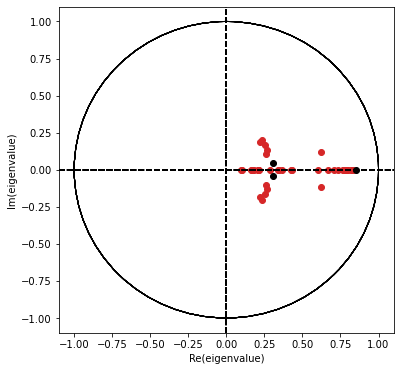

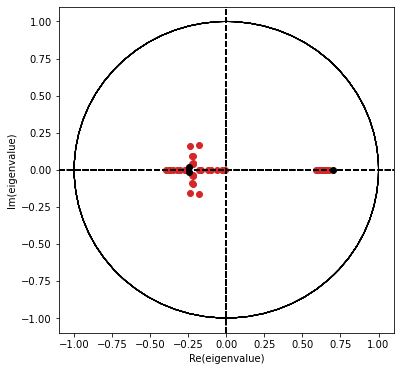

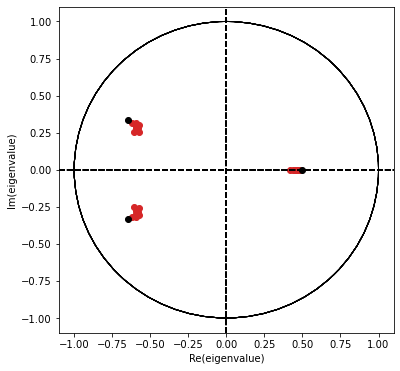

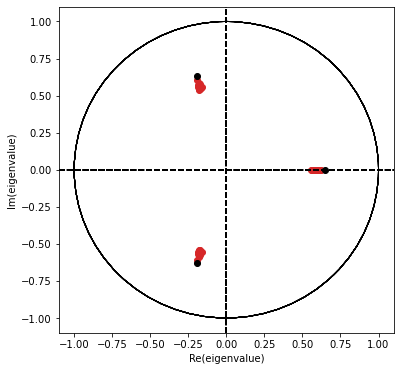

In [6]:
for eig in range(10):
    fig, axes = plt.subplots(figsize=(6,6))
    for simulation in range(30):
        # RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig,simulation], seed=1)
        # fitW = RNN.build_full_weight_matrix(w[eig, simulation])
        if binary_unstable_init[eig,simulation] == 0:
            plot_eigenvalues(axes, np.linalg.eigvals(build_dynamics_matrix_A(initW[eig, simulation], J[eig, simulation])), color='tab:red', label='fit A')
    
    plot_eigenvalues(axes, np.linalg.eigvals(trueA[eig,simulation]), color='black', label='true A')


Text(0.5, 0, 'eigenvalue set')

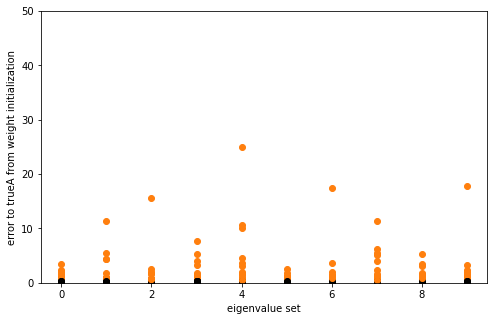

In [7]:
fig, axes = plt.subplots(figsize=(8,5))
for eig in range(10):
    for simulation in range(30):
        # RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig,simulation], seed=1)
        # fitW = RNN.build_full_weight_matrix(w[eig, simulation])
        diff = build_dynamics_matrix_A(initW[eig, simulation], J[eig, simulation]) - trueA[eig, simulation]
        error = np.sqrt(np.trace(diff.T @ diff))
        if binary_unstable_init[eig, simulation] == 0:
            axes.scatter(eig, error, color='black')
        else:
            axes.scatter(eig, error, color='tab:orange')

axes.set_ylim(0,50)
axes.set_ylabel('error to trueA from weight initialization')
axes.set_xlabel('eigenvalue set')

In [28]:
print(fitW[eig, simulation])

[[ 0.15559535  0.          0.28358156 ...  0.          0.
  -0.12871434]
 [ 0.02868897  0.04589845  0.         ...  0.          0.
  -0.09420809]
 [ 0.01208701  0.          0.07573625 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.12440935 -0.10080602
   0.        ]
 [ 0.12115227  0.          0.11971202 ...  0.         -0.12768674
   0.        ]
 [ 0.04287742  0.          0.         ...  0.          0.
  -0.01985564]]


0


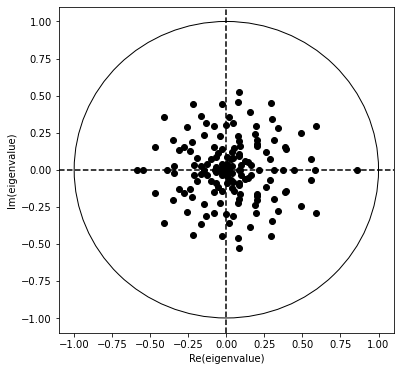

In [38]:

fig, axes = plt.subplots(figsize=(6,6))
plot_eigenvalues(axes, np.linalg.eigvals(fitW[0,28]), color='black')

eig_fit = np.linalg.eigvals(fitW[0,28]) 
eig_norms = norm_complex_scalar(eig_fit)
print(len(np.argwhere(eig_norms > 1)))


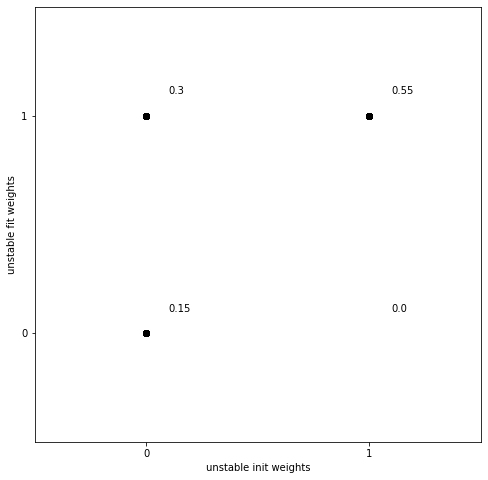

In [40]:
# whether instability in fitting is solely caused by instability in initialization
binary_unstable_fit = np.zeros((10, 30))
count_unstable_fit = np.zeros((10, 30))
fig, axes = plt.subplots(figsize=(8,8))

count = np.zeros((2,2))
for eig in range(10):
    for simulation in range(30):
        
        eig_fit = np.linalg.eigvals(fitW[eig,simulation]) 
        eig_norms = norm_complex_scalar(eig_fit)
        if len(np.argwhere(eig_norms > 1)) > 0: # if at least one unstable
            binary_unstable_fit[eig, simulation] = 1
            count_unstable_fit[eig, simulation] = len(np.argwhere(eig_norms > 1))
        axes.scatter(binary_unstable_init[eig, simulation], binary_unstable_fit[eig, simulation], color='black')
        count[int(binary_unstable_init[eig, simulation]), int(binary_unstable_fit[eig, simulation])] += 1

axes.set_ylim(-0.5,1.5)
axes.set_xlim(-0.5,1.5)

N_all = 10 * 30
axes.text(0.1,0.1, np.round(count[0,0]/N_all,2))
axes.text(0.1,1.1, np.round(count[0,1]/N_all,2))
axes.text(1.1,0.1, np.round(count[1,0]/N_all,2))
axes.text(1.1,1.1, np.round(count[1,1]/N_all,2))
axes.set_xlabel('unstable init weights')
axes.set_ylabel('unstable fit weights')
axes.set_xticks([0,1],[0,1])
axes.set_yticks([0,1],[0,1])

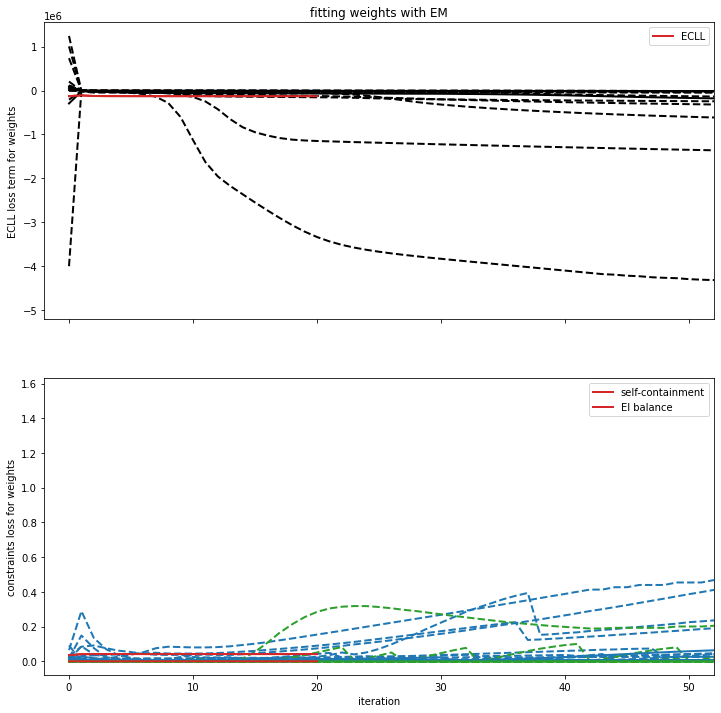

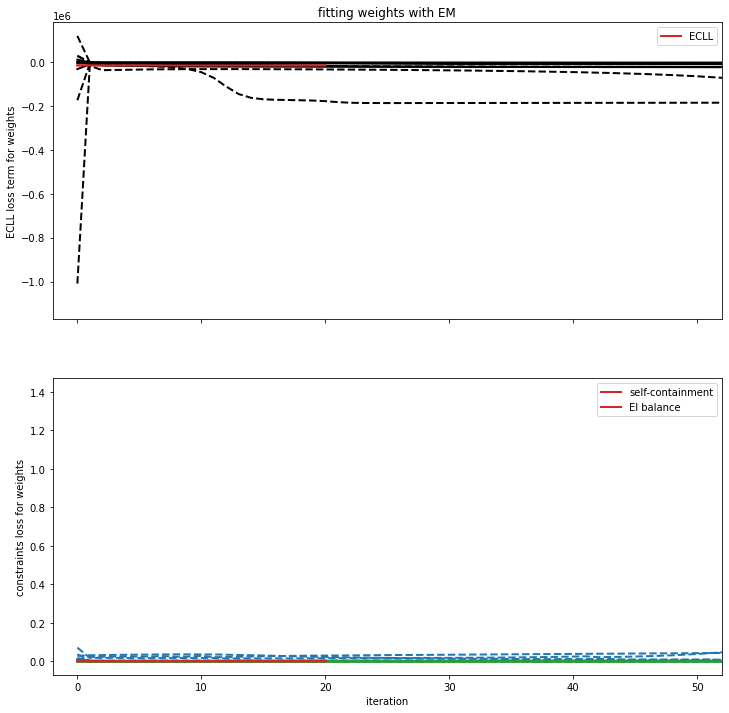

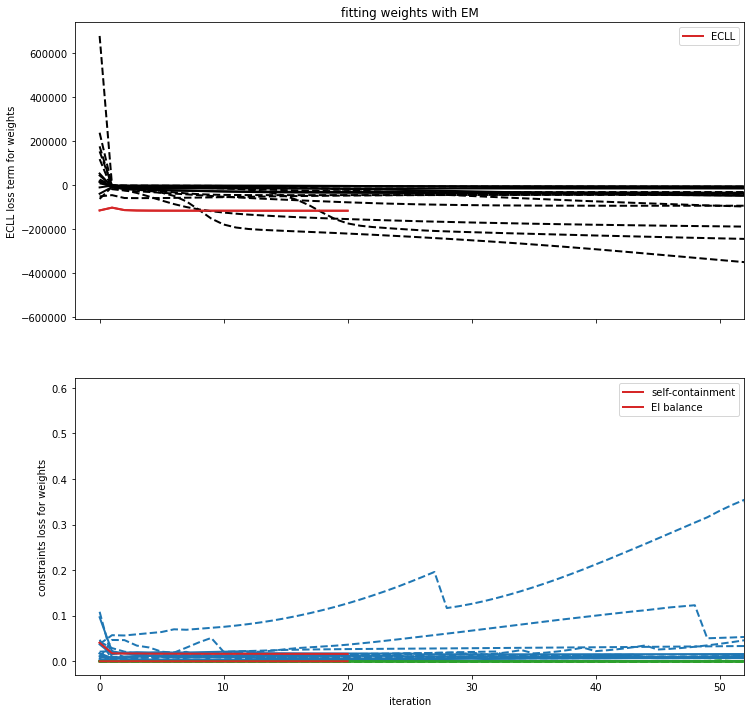

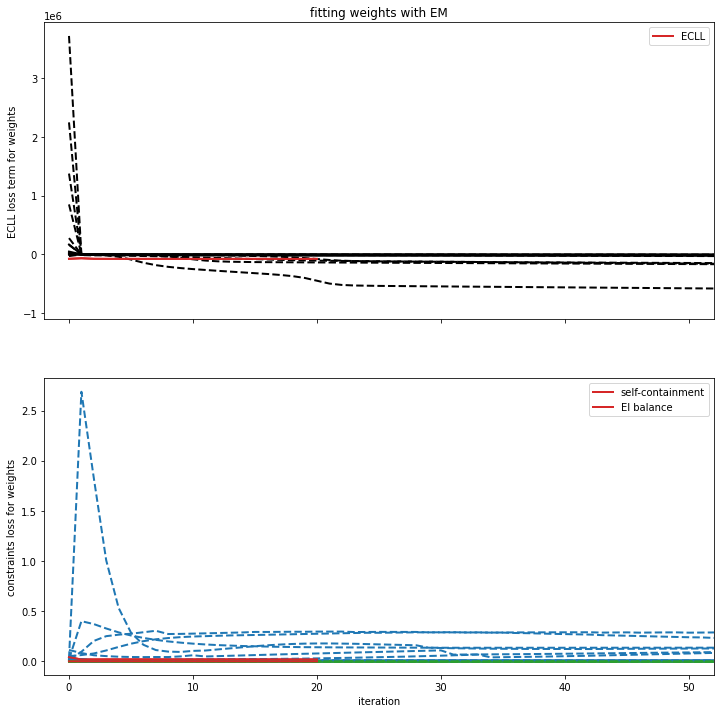

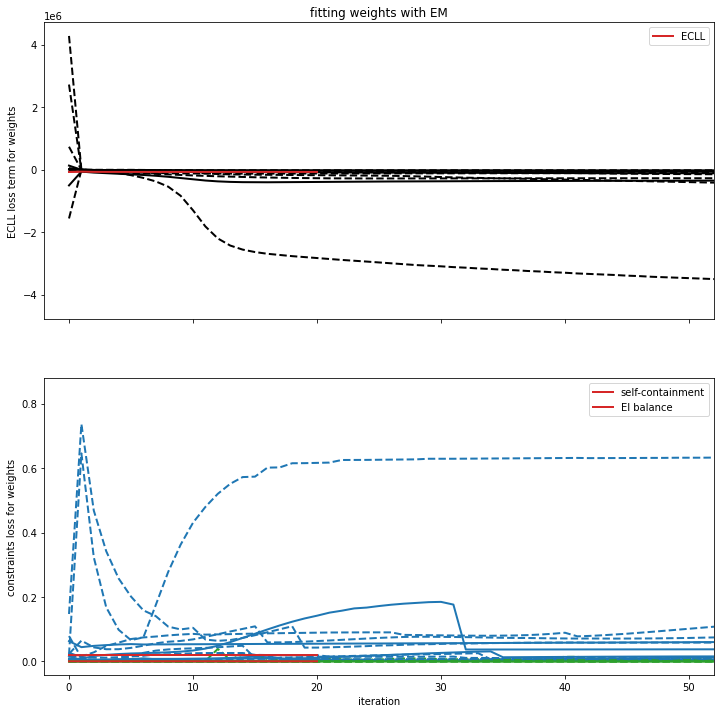

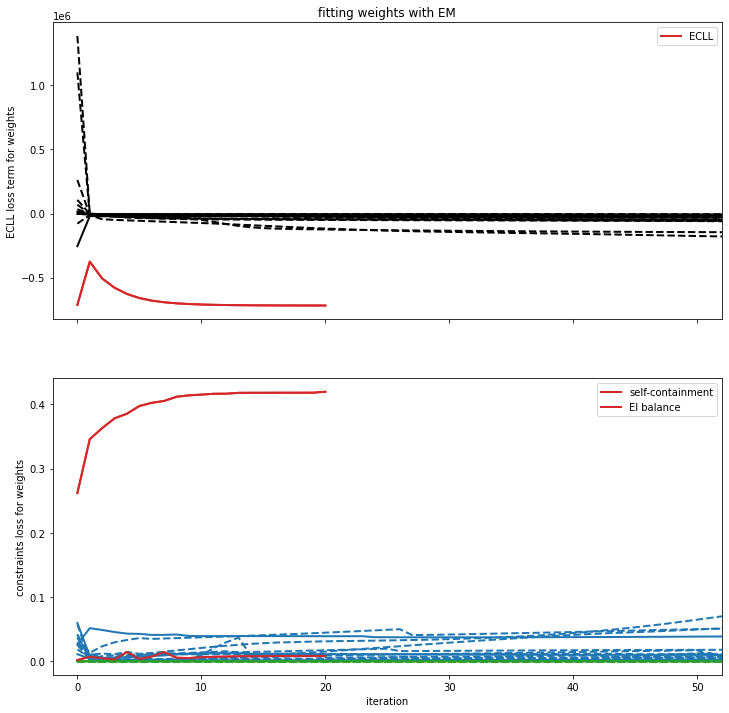

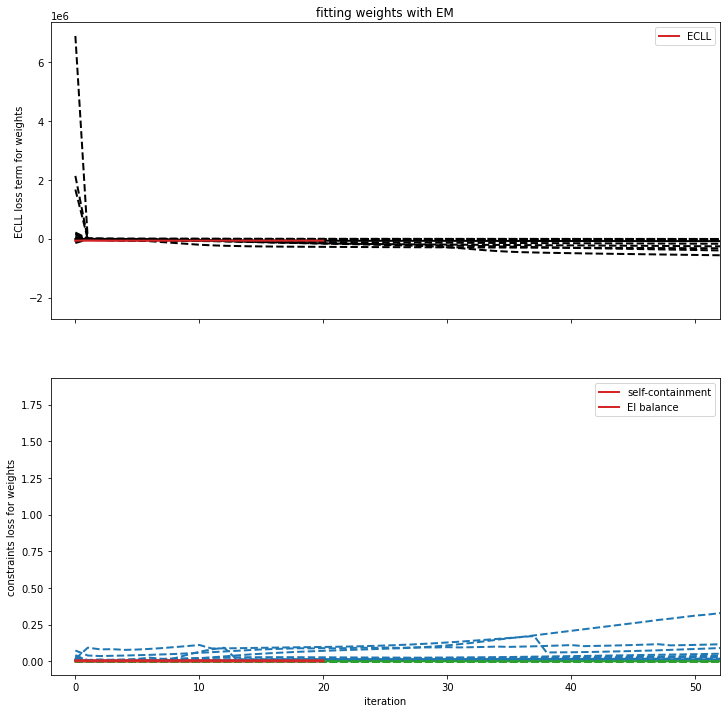

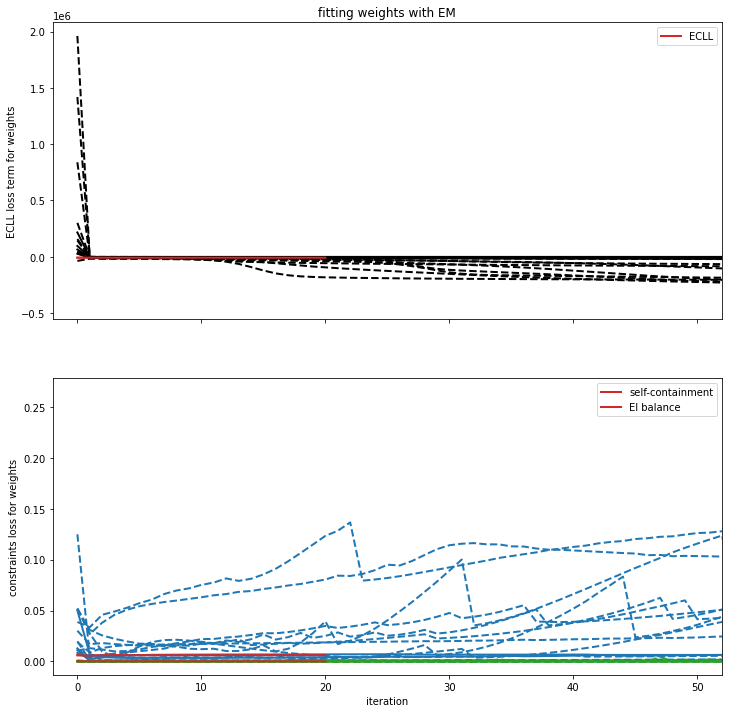

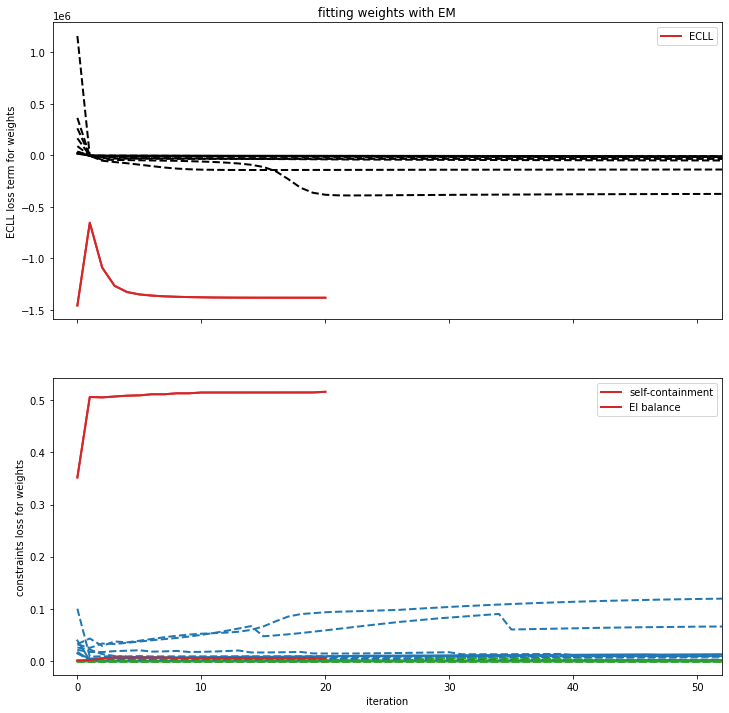

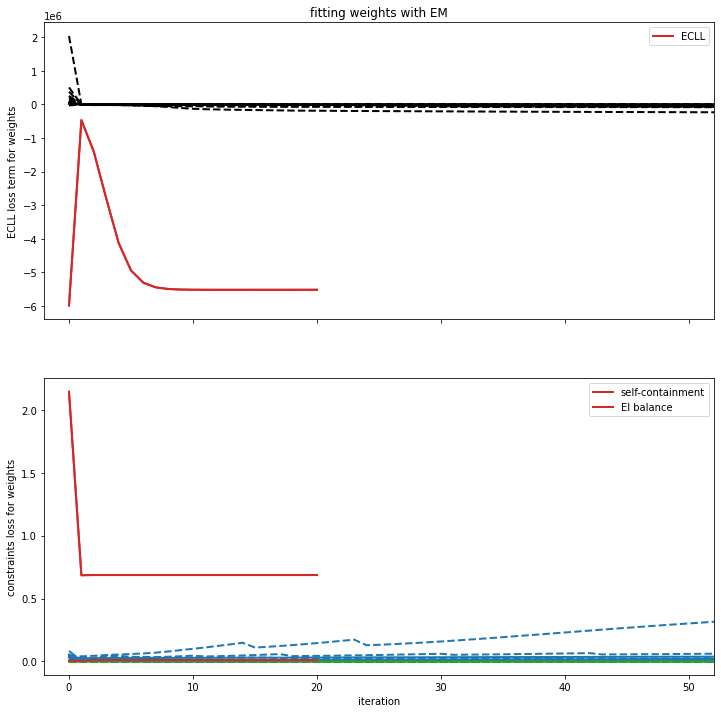

In [41]:
# fitting with EM
for eig in range(10):
    fig, axes = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(12,12))
    for simulation in range(30):
        if simulation == 0:
            axes[0].plot(range(20+1), lossW[eig,0][:,0], color='tab:red', label='ECLL', linewidth=2)
            # axes[0].scatter(range(20+1), lossW[eig,simulation][:,0], color='black')
            axes[1].plot(range(20+1), lossW[eig,0][:,1], color='tab:red', label='self-containment',linewidth=2)
            # axes[1].scatter(range(20+1), lossW[eig,simulation][:,1], color='tab:blue')
            axes[1].plot(range(20+1), lossW[eig,0][:,2], color='tab:red', label='EI balance', linewidth=2)
        else:
            if binary_unstable_init[eig,simulation] == 0:
                if binary_unstable_fit[eig, simulation] == 0:
                    axes[0].plot(range(200+1), lossW[eig,simulation][:,0], color='black',linewidth=2)
                    # axes[0].scatter(range(200+1), lossW[eig,simulation][:,0], color='black')
                    axes[1].plot(range(200+1), lossW[eig,simulation][:,1], color='tab:blue',linewidth=2)
                    # axes[1].scatter(range(200+1), lossW[eig,simulation][:,1], color='tab:blue')
                    axes[1].plot(range(200+1), lossW[eig,simulation][:,2], color='tab:green',linewidth=2)
                    # axes[1].scatter(range(200+1), lossW[eig,simulation][:,2], color='tab:green')
                else:
                    axes[0].plot(range(200+1), lossW[eig,simulation][:,0], color='black',linewidth=2, linestyle='dashed')
                    # axes[0].scatter(range(200+1), lossW[eig,simulation][:,0], color='black')
                    axes[1].plot(range(200+1), lossW[eig,simulation][:,1], color='tab:blue',linewidth=2, linestyle='dashed')
                    # axes[1].scatter(range(200+1), lossW[eig,simulation][:,1], color='tab:blue')
                    axes[1].plot(range(200+1), lossW[eig,simulation][:,2], color='tab:green',linewidth=2, linestyle='dashed')
                    # axes[1].scatter(range(200+1), lossW[eig,simulation][:,2], color='tab:green')


    # simulation 0 in red
    axes[0].plot(range(20+1), lossW[eig,0][:,0], color='tab:red', linewidth=2)
    # axes[0].scatter(range(20+1), lossW[eig,simulation][:,0], color='black')
    axes[1].plot(range(20+1), lossW[eig,0][:,1], color='tab:red', linewidth=2)
    # axes[1].scatter(range(20+1), lossW[eig,simulation][:,1], color='tab:blue')
    axes[1].plot(range(20+1), lossW[eig,0][:,2], color='tab:red', linewidth=2)
    axes[0].set_title('fitting weights with EM')
    axes[0].set_ylabel('ECLL loss term for weights')
    axes[0].legend()
    axes[1].legend()
    axes[1].set_ylabel('constraints loss for weights')
    axes[1].set_xlabel('iteration')
    axes[1].set_xlim(-2,52)

# fig, axes = plt.subplots(figsize=(8,5))
# axes.plot(range(max_iter+1), lossW[:,1], color='tab:blue', label='self-containment')
# axes.scatter(range(max_iter+1), lossW[:,1], color='tab:blue')
# axes.plot(range(max_iter+1), lossW[:,2], color='tab:green', label='EI balance')
# axes.scatter(range(max_iter+1), lossW[:,2], color='tab:green')
# axes.legend()
# axes.set_title('fitting weights with EM')
# axes.set_ylabel('loss term for weights')
# axes.set_xlabel('iteration')


Text(0.5, 0, 'eigenvalue set')

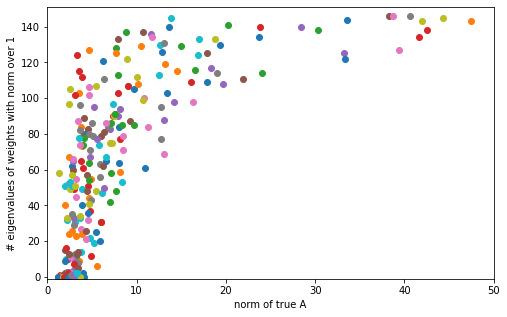

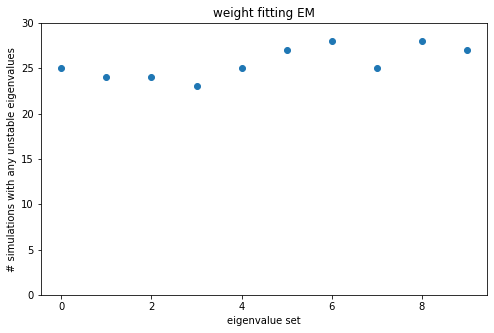

In [43]:
# unstable fit as a function of norm of A

fig, axes = plt.subplots(figsize=(8,5))
for eig in range(10):
    for simulation in range(30):
        axes.scatter(norm_A[eig,simulation], count_unstable_fit[eig,simulation])
axes.set_xlim(0,50)
axes.set_ylabel('# eigenvalues of weights with norm over 1')
axes.set_ylim(-1,N+1)
axes.set_xlabel('norm of true A')

fig, axes = plt.subplots(figsize=(8,5))
axes.scatter(range(10),binary_unstable_fit.sum(axis=1))
axes.set_ylim(0,30)
axes.set_ylabel('# simulations with any unstable eigenvalues')
axes.set_title('weight fitting EM')
axes.set_xlabel('eigenvalue set')

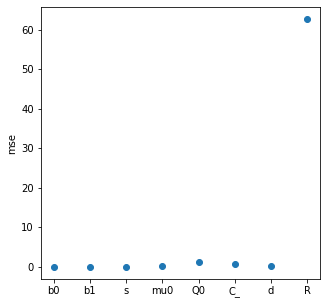

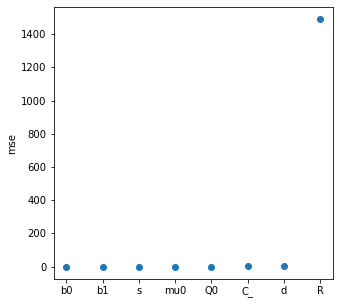

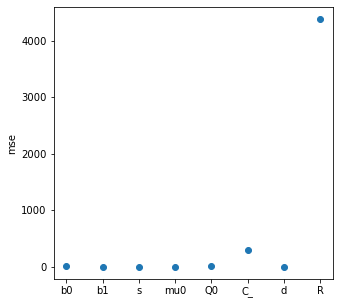

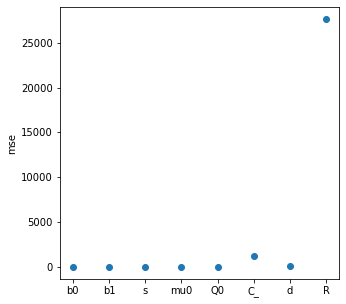

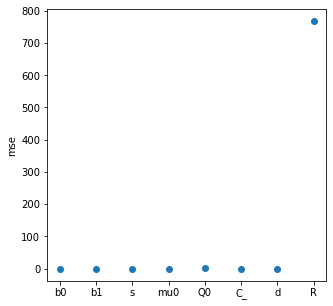

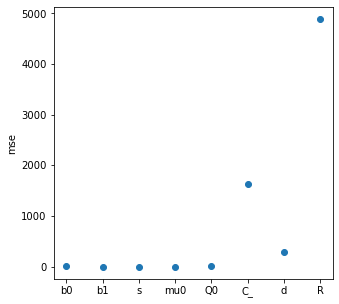

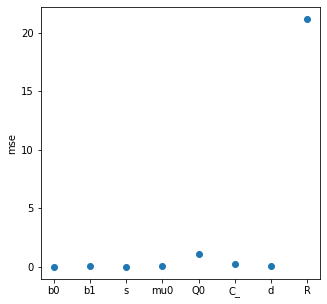

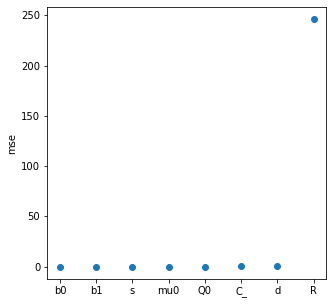

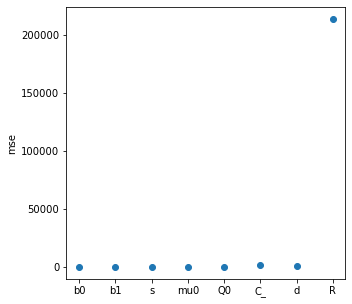

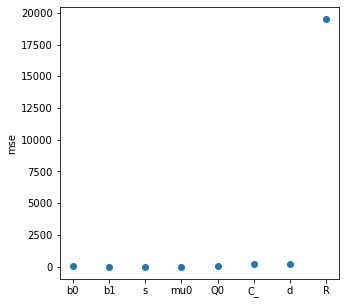

In [104]:
for eig in range(10):
    fig, axes = plt.subplots(figsize=(5,5))
    for simulation in range(30):
        if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: 
            plot_mse_parameters(axes, b[eig,simulation].item(), s[eig,simulation], mu0[eig,simulation], Q0[eig,simulation], C_[eig,simulation], d[eig,simulation], R[eig,simulation], true_b[eig,simulation].item(), true_s[eig,simulation], true_mu0[eig,simulation], true_Q0[eig,simulation], true_C_[eig,simulation], true_d[eig,simulation], true_R[eig,simulation])

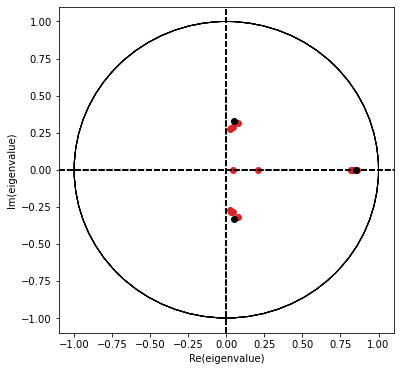

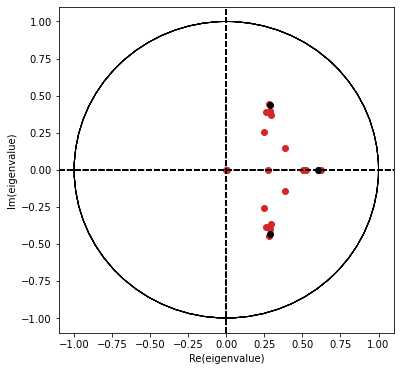

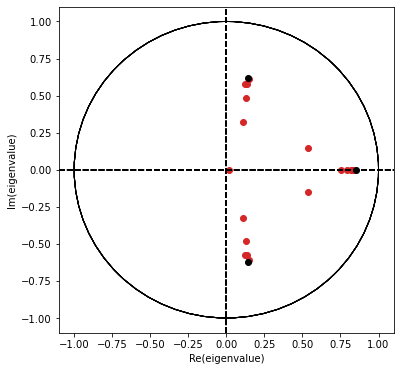

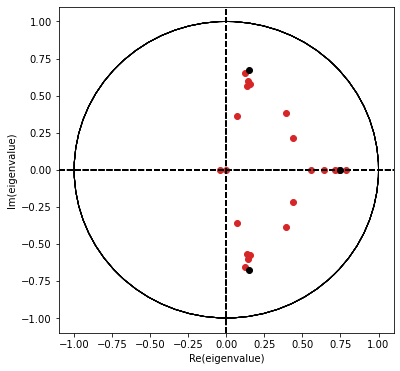

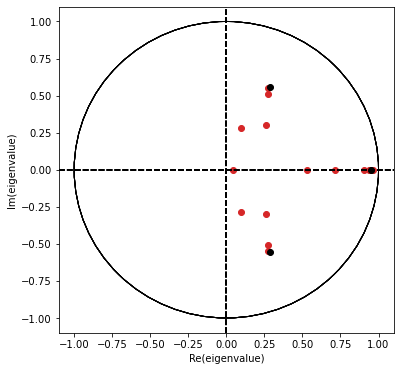

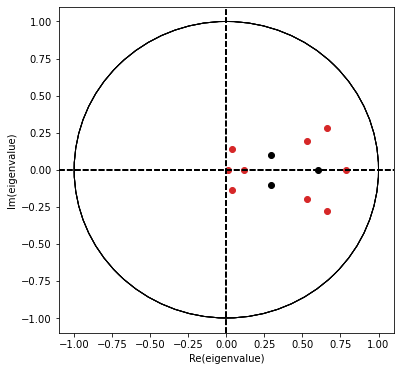

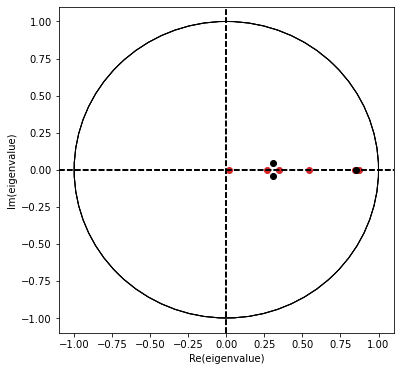

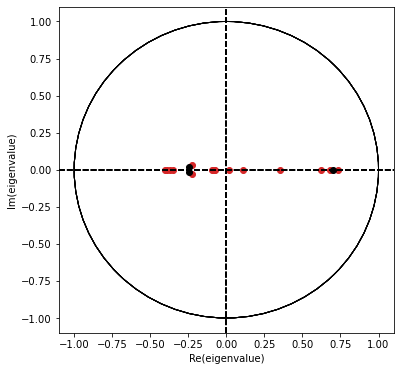

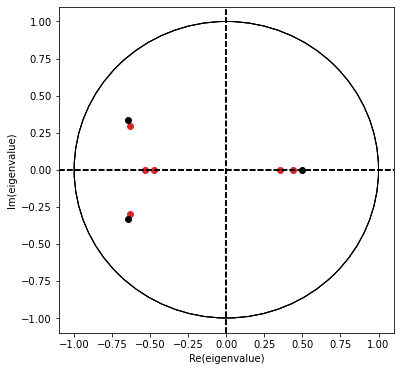

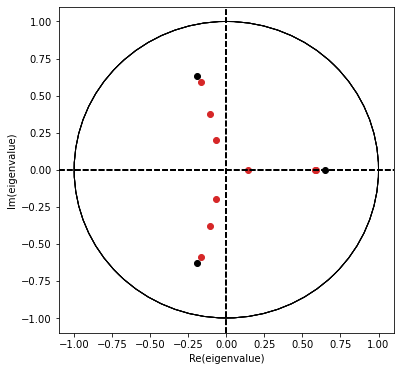

In [105]:
for eig in range(10):
    fig, axes = plt.subplots(figsize=(6,6))
    for simulation in range(30):
        # RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig,simulation], seed=1)
        # fitW = RNN.build_full_weight_matrix(w[eig, simulation])
        if binary_unstable_fit[eig,simulation] == 0:
            plot_eigenvalues(axes, np.linalg.eigvals(build_dynamics_matrix_A(fitW[eig, simulation], J[eig, simulation])), color='tab:red', label='fit A')
    
    plot_eigenvalues(axes, np.linalg.eigvals(trueA[eig,simulation]), color='black', label='true A')


In [106]:
# alignment of two subspaces - variance explained in projection (for stable weights)

def covariance_alignment(v, J, B):
    # project network on low-dim PC space
    cov_network = v.T @ v
    proj_v = v @ B
    cov_PCA = proj_v.T @ proj_v

    proj_J = J @ v.T
    cov_J = proj_J @ proj_J.T
    
    return np.trace(cov_J) / np.trace(cov_network), np.trace(cov_PCA)/np.trace(cov_network)

fraction_cov_var_PCA = np.zeros((10, 30))
fraction_cov_var_J = np.zeros((10, 30))
for eig in range(10):
    for simulation in range(30):
        

        if binary_unstable_init[eig, simulation] == 0 and binary_unstable_fit[eig,simulation] == 0: # both init and fit weights are stable
            RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J[eig, simulation],  seed=1)
            # print(fitW[eig, simulation].shape)
            # print(mu0[eig, simulation].shape)
            # print(Q0[eig, simulation].shape)
            v = RNN.generate_network_activity(U, T, fitW[eig, simulation], b[eig, simulation].item(), float(s[eig, simulation]), mu0[eig, simulation], Q0[eig, simulation])

            # PCA on data
            v_concat = v.reshape(v.shape[0] * v.shape[1], v.shape[2])
            # v_avg = v.mean(axis=0).reshape(v.shape[1], v.shape[2])
            # mean = v_avg.mean(axis=0)
            mean = v_concat.mean(axis=0)

            # mean-center
            v_concat = v_concat - mean
            # v_mean = v_avg - mean

            eigval_PCA, eigvec_PCA = np.linalg.eig(v_concat.T @ v_concat) # eigvec 0 is eigvec[:,0] - columns
            ones = np.ones((v_concat.shape[1]))
            # eigval, eigvec = np.linalg.eig(v_mean.T @ v_mean) # eigvec 0 is eigvec[:,0] - columns
            # ones = np.ones((v_mean.shape[1]))
            idx = np.argsort(eigval_PCA)[::-1]
            eigval_PCA = eigval_PCA[idx]
            eigvec_PCA = eigvec_PCA[:,idx]

            dim_PCA = 3

            fraction_cov_var_J[eig, simulation], fraction_cov_var_PCA[eig,simulation] = covariance_alignment(v_concat, J[eig,simulation], eigvec_PCA[:,:dim_PCA])

            # # variance explained in PCA
            # fig, axes = plt.subplots(figsize=(7,5))
            # var_explained_pc = np.zeros((v_concat.shape[1]))
            # cumul_var_explained_pc = np.zeros((v_concat.shape[1]))
            # axes2 = axes.twinx()
            # for i in range(var_explained_pc.shape[0]):
            #     var_explained_pc[i] = eigval_PCA[i] / eigval_PCA.sum()
            #     cumul_var_explained_pc[i] = var_explained_pc[:i+1].sum()
            # axes.plot(range(10), var_explained_pc[:10], color='black')
            # axes.scatter(range(10), var_explained_pc[:10], label='individual', color='black')
            # axes2.plot(range(10), cumul_var_explained_pc[:10], color='gray')
            # axes2.scatter(range(10), cumul_var_explained_pc[:10], label='cumulative', color='gray')
            # axes.axhline(0, color='black', linestyle='dashed')
            # axes.set_ylabel('variance explained')
            # axes2.set_ylabel('cumulative variance explained')
            # axes.set_xlabel('PC dimension')
            # axes.set_xticks(range(10),range(1,11))
            # axes2.set_ylim(0,1.05)
            # axes.set_title(f'PCA on network - eig set = {eig}')
            

In [99]:
print(fraction_cov_var_J.shape)
print(fraction_cov_var_PCA.shape)

(10, 30)
()


(0.0, 0.7)

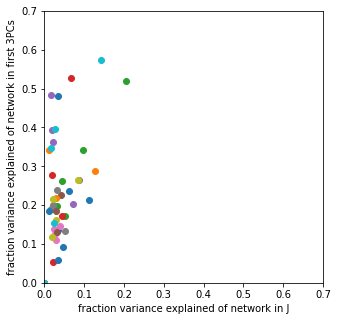

In [108]:
fig, axes = plt.subplots(figsize=(5,5))
for eig in range(10):
    for simulation in range(30):
        axes.scatter(fraction_cov_var_J[eig,simulation],fraction_cov_var_PCA[eig,simulation])
axes.set_xlabel('fraction variance explained of network in J')
axes.set_ylabel('fraction variance explained of network in first 3PCs')
axes.set_xlim(0,0.7)
axes.set_ylim(0,0.7)